# Introduction

In this notebook I am going to discover, prepare and transform the text data with the TF-IDF measure.
The dataset is avaiable at: https://www.kaggle.com/c/nlp-getting-started/data

Let' see what we can expect according to Kaggle.

>**What should I expect the data format to be?**
>Each sample in the train and test set has the following information:

>**The text of a tweet**
>A keyword from that tweet (although this may be blank!)
>The location the tweet was sent from (may also be blank)
>What am I predicting?
>You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

>**Columns:**
>id - a unique identifier for each tweet
>text - the text of the tweet
>location - the location the tweet was sent from (may be blank)
>keyword - a particular keyword from the tweet (may be blank)
>target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


First let's import the relevant libraries and take a look at the data...

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Data preprocessing

The data must be machine readable in order to apply any algorithms. The missing values must be filled or deleted and the categorical variables encoded.

It seems there are lots of missing values to be dealt with, let's create a heatmap to visualize the null values.

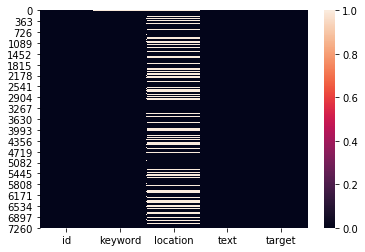

In [3]:
sns.heatmap(train.isnull())

There are also a lot of unique values in each column...

In [4]:
print("Number of unique values of the keyword column: {}".format(train['keyword'].nunique()))
print("Number of unique values of the location column: {}".format(train['location'].nunique()))

Number of unique values of the keyword column: 221
Number of unique values of the location column: 3341


I accidentaly discovered some anomaly in the *location* column:

In [5]:
train[train['location']=='M!$$!$$!PP!']['location']

3192    M!$$!$$!PP!
Name: location, dtype: object

The values in the *location* column a probably results of user inputs, so some location may be false or nonexistent, thus we can decide to delete the *location* column with consideration of the missing values.

In [6]:
train = train.drop('location', axis=1)

Let's have a look on the unique values of the *keyword* column...

In [7]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

Many of the words above have a negative meaning, but some of them may be unrelated to an actual disaster such as 'lightning' or 'smoke'.

The Nan values of the *keyword* column must be replaced with a word before creating dummy variables.

In [8]:
train['keyword'].fillna(value='Unknown', inplace=True)

Some metadata could be extracted from the dataset such as length of tweets, length of keyword and number of hashtags in a tweet. Let's add two new columns corresponding to length of tweets and length of keywords.

In [9]:
train['length_tweet'] = train['text'].apply(len)
train['length_keyword'] = train['keyword'].apply(len)

Let's define a function to count the number of hashtags in each tweet, then apply it on the *text* column.

In [10]:
def count_ht(tweet):
    ht = 0
    for char in tweet:
        if char == '#':
            ht +=1
    return ht
train['ht_number'] = train['text'].apply(count_ht)

The new, preprocessed dataset...

In [11]:
train.head()

,id,keyword,text,target,length_tweet,length_keyword,ht_number
0,1,Unknown,Our Deeds are the Reason of this #earthquake M...,1,69,7,1
1,4,Unknown,Forest fire near La Ronge Sask. Canada,1,38,7,0
2,5,Unknown,All residents asked to 'shelter in place' are ...,1,133,7,0
3,6,Unknown,"13,000 people receive #wildfires evacuation or...",1,65,7,1
4,7,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,88,7,2


# Exploratory data analysis

Now that the preprocessed data is avaiable we can do some EDA to further explore the data.



Let's create a countplot for the disaster and non-disaster tweets.

Text(0, 0.5, 'Number of tweets')

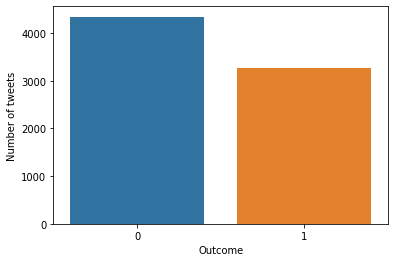

In [12]:
sns.countplot(x='target', data=train)
plt.xlabel('Outcome')
plt.ylabel('Number of tweets')

Let's see the histograms of the tweet lengths of the *text* column.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028E0DD5C1C8>,
      dtype=object)

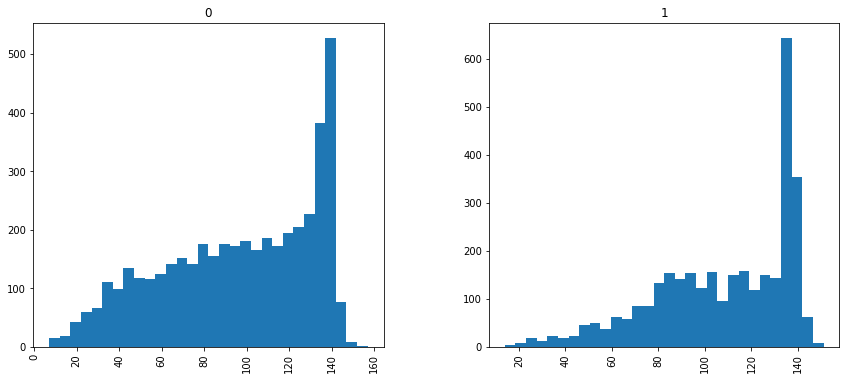

In [13]:
train.hist(column='length_tweet', by='target', bins=30, figsize=(14, 6))

Tweets about disasters are tend to be slightly longer...

Let's see if there are any correlation between the continous data of the dataset.

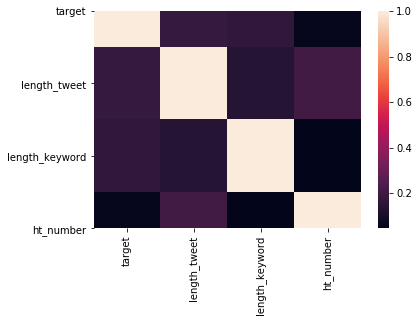

In [14]:
sns.heatmap(train.drop(['id', 'keyword', 'text'], axis=1).corr())

We cannot see any strong correlation

# Preprocessing the *text* column

In order to make the text machine readable, the text must be converted into vectors.

First import some libraries...

In [15]:
import string
from nltk.corpus import stopwords

### Tokenizing function

Any special charachters must be removed as well as English stopwords such as 'the', 'and' etc. Presumably these stopwords occurs randomly in most of the tweets, so they doesn't offer additional information besides the tweet content.

Let's define a function that can be used to vectorize each tweet.

In [16]:
def text_process(tw):
    """
    :tw: Text(string) 
    Returns a list for each tweet as a list of each word count in the tweet.
    """
    
    nopunc = [char for char in tw if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Let's create a vectorizer object and fit it on the *text* column.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
bowt = CountVectorizer(analyzer=text_process)
bowt.fit(train['text'])

CountVectorizer(analyzer=<function text_process at 0x0000028E0F3A4678>,
                binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Let's see how many unique word are we dealing with...

In [18]:
print(len(bowt.vocabulary_))

26473


We can create the bags of words for the whole *text* column.

In [19]:
tweet_bow = bowt.transform(train['text'])

### TF-IDF transforming

Let's create a transformer object to fit the Bag of Words of the *text* column and then create a sparse matrix

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_idf_tw = TfidfTransformer()
tf_idf_tw.fit(tweet_bow)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

The sparse matrix...

In [21]:
text_tfidf = tf_idf_tw.transform(tweet_bow)
type(text_tfidf)

scipy.sparse.csr.csr_matrix

The sparse matrix could be transformed to a Pandas data frame and then concatenated with the original data frame.

In [22]:
tf_idf_df = pd.DataFrame(text_tfidf.toarray())
pr_train = pd.concat([train.drop(labels=['text'], axis=1), tf_idf_df], axis=1)

In [23]:
pr_train.head()

,id,keyword,target,length_tweet,length_keyword,ht_number,0,1,2,3,...,26463,26464,26465,26466,26467,26468,26469,26470,26471,26472
0,1,Unknown,1,69,7,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,Unknown,1,38,7,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,Unknown,1,133,7,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,Unknown,1,65,7,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,Unknown,1,88,7,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Get dummy variables for the *keyword* column and drop the *id* column...

In [24]:
pr_train = pd.get_dummies(data=pr_train, columns=['keyword'], drop_first=True)

In [25]:
pr_train = pr_train.drop(labels=['id'], axis=1)
pr_train.head()

,target,length_tweet,length_keyword,ht_number,0,1,2,3,4,5,...,keyword_weapons,keyword_whirlwind,keyword_wild%20fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
0,1,69,7,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,38,7,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,133,7,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,65,7,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,88,7,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


The data is now fully processed.

# Naive-Bayes classifier

Naive-Bayes is a commonly used classifier for text data.

Splitting the data to training set and test set...

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X = pr_train.drop(labels=['target'], axis=1)
y = pr_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X.shape

(7613, 26697)

Creating a classifier object and fitting the training data...

In [28]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy results and confusion matrix of the Naive-Bayes classifier.

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
pred_NB = classifier.predict(X_test)
print(confusion_matrix(y_test, pred_NB))
print(classification_report(y_test, pred_NB))

[[1208   72]
 [ 515  489]]
              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1280
           1       0.87      0.49      0.62      1004

    accuracy                           0.74      2284
   macro avg       0.79      0.72      0.71      2284
weighted avg       0.78      0.74      0.73      2284

